In [1]:
def sort_unity_files(path, mask):
    """
    Create a sorted dictionary from unity (SDSandbox) files e.g. 
    C:\\Users\\aczd097\\Downloads\\dataset\\unity\\log_sample\\logs_Mon_Jul_13_08_29_01_2020\\0_cam-image_array_.jpg
    Where the key in example above is 0 (first characters before underscore in 0_cam-image_array_.jpg)
    
    --------
    
    Input:
        path, string, path to files
        mask, string, file type
    
    -------
    
    Output:
        Sorted dictionary containing key and file path
    
    -------
            
    Example:
    path = 'C:\\Users\\aczd097\\Downloads\\dataset\\unity\\log_sample\\logs_Mon_Jul_13_08_29_01_2020\\'
    mask = '*.jpg'
    fdict = sort_unity_files(path, mask)
    for key in sorted(fdict):
        print("key: {}, value:{}".format(key,fdict[key]))
    
    -------
       
    Notes:
    File path format is OS dependant, OrderedDict must by sorted to order files in the right order.
    """
    
    import fnmatch
    import os
    from collections import OrderedDict

    #path = 'C:\\Users\\aczd097\\Downloads\\dataset\\unity\\log_sample\\logs_Mon_Jul_13_08_29_01_2020\\'
    #mask = '*.jpg'
    filemask = os.path.expanduser(path +  mask)
    path, mask = os.path.split(filemask)

    fdict = OrderedDict()
    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            fdict[int(filename.split('_')[0])] = os.path.join(root, filename)

    return fdict

In [ ]:
# TODO Finish writing this function, looping through fdict instead of current scheme
# Goods-to-have plot RGB distribution on the video as it goes along
def make_video(fdict, model, preproc=False):
    """
    Make video from image dictionary.
    video.avi is written to disk
    
    -------
    
    Inputs
        fdict: collections.OrderedDict, ordered dictionary of file names
        model: string, model name
        preproc: boolean, show preprocessed image next to original
        
    -------
    
    Output
        none
    
    -------
    
    Example

    path = 'C:\\Users\\aczd097\\Downloads\\dataset\\unity\\log_sample\\logs_Mon_Jul_13_08_29_01_2020\\'
    mask = '*.jpg'
    fdict = sort_unity_files(path, mask)
    
    model = 'nvidia2'
    make_video(fdict, model, True);
    
    
    """
    
    import os
    import sys
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)


    import argparse
    import fnmatch
    import json
    import os
    from io import BytesIO
    from PIL import Image
    import base64
    import numpy as np
    import matplotlib.pyplot as plt
    from augmentation import preprocess
    import cv2
    import conf    
    
    # video name
    video_name = model + '.avi'
    VIDEO_WIDTH, VIDEO_HEIGHT = 800, 600
    IMAGE_WIDTH, IMAGE_HEIGHT = 800, 600
    if(preproc == True): # wide angle
        VIDEO_WIDTH = IMAGE_WIDTH*2
    video = cv2.VideoWriter(video_name, 0, 11, (VIDEO_WIDTH, VIDEO_HEIGHT)) # assumed 11fps
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # normalization constant
    # open file
    sa = []
    # initialize prediction
    pred = ''
    f = open(filename, "r")
    file = f.read()
    try:
        #readline = f.read()
        lines = file.splitlines()
        for line in lines:
            #print(line)
            start = line.find('{')
            if(start == -1):
                continue
            jsonstr = line[start:]
            #print(jsonstr)
            jsondict = json.loads(jsonstr)
            if "steering" in jsondict:
                # predicted
                pred = jsondict['steering']
            if "steering_angle" in jsondict:
                # actual
                act = jsondict['steering_angle']
                # save pair, only keep last pred in case two were send as it does happen i.e.:
                # 127.000.000.001.59460-127.000.000.001.09091: {"msg_type": "control", "steering": "-0.071960375", "throttle": "0.08249988406896591", "brake": "0.0"}
                # 127.000.000.001.59460-127.000.000.001.09091: {"msg_type": "control", "steering": "-0.079734944", "throttle": "0.08631626516580582", "brake": "0.0"}
                # 127.000.000.001.09091-127.000.000.001.59460: {"msg_type":"telemetry","steering_angle":-0.07196037,(...)
                if(len(pred) > 0):
                    # save steering angles
                    sa.append([float(pred), act])
                    pred = '' # need to save this image
                    # process image
                    imgString = jsondict["image"]
                    # decode string
                    image = Image.open(BytesIO(base64.b64decode(imgString)))
                    # try to convert to jpg
                    #image = np.array(image) # sky colour turns orange (TODO investigate)
                    # save
                    image.save('frame.jpg')
                    # reopen with user-friendlier cv2
                    image = cv2.imread('frame.jpg') # 120x160x3
                    image_copy = image
                    # resize so we can write some info onto image
                    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
                    # add Info to frame
                    cv2.putText(image, model, (50, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
                    # Predicted steering angle
                    pst = sa[len(sa)-1][0]
                    pst *= conf.norm_const
                    simst = "Predicted steering angle: {:.2f}".format(pst)
                    cv2.putText(image, simst, (50, 115), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
                    # create a preprocessed copy to compare what simulator generates to what network "sees"
                    if (preproc == True):  # wide angle
                        image2 = preprocess(image_copy)
                        image2 = cv2.resize(image2, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
                        cv2.putText(image2, 'Network Image', (50, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
                    # concatenate
                    if (preproc == True):  # wide angle
                        cimgs = np.concatenate((image, image2), axis=1)
                        image = cimgs
                    # model name
                    # model
                    video.write(image);
                    pred = ''
    except Exception as e:
        print("Exception raise: " + str(e))
    # file should be automatically closed but will close for good measure
    f.close()
    cv2.destroyAllWindows()
    video.release()


    return "DummyName.mp4"
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Make Video script')
    parser.add_argument('--filename', type=str, help='tcpflow log')
    parser.add_argument('--model', type=str, help='model name for video label')
    args = parser.parse_args()
    MakeVideo(args.filename, args.model, True)
    # example
    # python MakeVideo.py --filename=/tmp/tcpflow.log --model=20201120184912_sanity.h5

In [32]:
import os
import sys
# find the current path, might not be necessary running as a .py script
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
import Augment_cls as Augmentation
ag = Augmentation.Augment_cls('nvidia2')  
import conf

path = 'C:\\Users\\aczd097\\Downloads\\dataset\\unity\\log_sample\\logs_Mon_Jul_13_08_29_01_2020\\'
mask = '*.jpg'
fdict = sort_unity_files(path, mask)
len(fdict) 


In [33]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(fdict[0]) 
plt.imshow(img)


In [64]:
import Augment_cls as Augmentation
ag = Augmentation.Augment_cls('nvidia2')

path = 'C:\\Users\\aczd097\\Downloads\\dataset\\unity\\log_sample\\logs_Mon_Jul_13_08_29_01_2020\\'
mask = '*.jpg'
fdict = sort_unity_files(path, mask)
print(type(fdict))
print(type(sorted(fdict)))
#for key in sorted(fdict):
#    print("key: {}, value:{}".format(key,fdict[key]))

len(fdict) 


<class 'collections.OrderedDict'>
<class 'list'>


12894

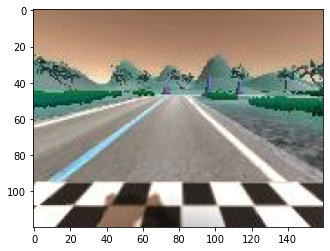

In [65]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(fdict[0]) 
plt.imshow(img)

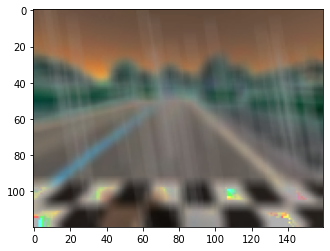

In [66]:
img_arr = add_rain(img, 'torrential', 20)
plt.imshow(img_arr)

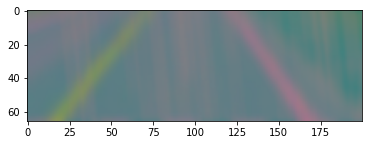

In [67]:
import numpy as np
# img_arr = np.asarray(img_arr, dtype=np.float32)

# set to same image size expected from acquisition process
img_arr = ag.resize_expected(img_arr)

# check for rain
#if(conf.rt != ''):
#    img_arr = add_rain(img_arr, conf.rt, conf.st)
#    self.img_add_rain = img_arr

# same preprocessing as for training
img_arr = ag.preprocess(img_arr)
plt.imshow(img_arr)       
# img = ag.preprocess(img)

In [18]:
# TODO, need to bring this from existing module
def add_rain(image_arr, rt=None, st=0):
    """
    Add rain to image
    Inputs:
        image_arr: numpy array containing image
        rt: string, rain type "heavy" or "torrential"
        st: range to draw a random slant from
    Output
        image_arr: numpy array containing image with rain
    """
    import Automold as am
    
    # print("Adding rain...")
    if(st != 0):
        # draw a random number for slant
        st = np.random.randint(-1 * st, st)

    if(rt!='light'): # heavy or torrential
        image_arr = am.add_rain_single(image_arr, rain_type=rt, slant=st)
    else:
         # no slant
        image_arr = am.add_rain_single(image_arr)

    return image_arr